In [27]:
import string
import random
import numpy as np
import pandas as pd
import re
import textwrap
import matplotlib.pyplot as plt

In [28]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)
random.shuffle(letters2)

mapping = {}
for l1,l2 in zip(letters1,letters2):
    mapping[l1]=l2

In [29]:
M = np.ones((26,26,26)) #Markov transition matrix
pi = np.ones(26) #initial state distribution

def UpdateTransition(char1,char2,char3):
    i = ord(char1) - 97
    j = ord(char2) - 97
    k = ord(char3) - 97
    
    M[i,j,k] +=1
def UpdateInitialStateDist(char1):
    i = ord(char1) - 97
    pi[i] +=1
def GetWordProb(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])
    
    
    for idx in range(1,len(word)-1):
        j = ord(word[idx]) - 97
        k = ord(word[idx+1]) - 97
        logp += M[i,j,k]
        
        i = j
    return logp
def GetSequenceOfProb(words):
    
    if type(words) == str:
        words = words.split()
    
    logp = 0
    for word in words:
        logp += GetWordProb(word)
        
    return logp

In [30]:
texts = pd.read_csv('moby_dick.txt',sep=r'\n',encoding='utf-8',header=None,engine='python')
texts.columns = ['Text']
texts

,Text
0,CHAPTER 1. Loomings.
1,Call me Ishmael. Some years ago—never mind how...
2,"little or no money in my purse, and nothing pa..."
3,"on shore, I thought I would sail about a littl..."
4,of the world. It is a way I have of driving of...
...,...
18386,"unharming sharks, they glided by as if with pa..."
18387,the savage sea-hawks sailed with sheathed beak...
18388,"sail drew near, nearer, and picked me up at la..."
18389,"devious-cruising Rachel, that in her retracing..."


In [31]:
regex = re.compile('[^a-zA-Z]')

for line in texts['Text']:
    line = line.rstrip()
    
    if line:
        line = regex.sub(' ',line)
        
        tokens = line.lower().split()
        
        for token in tokens:
            ch0 = token[0]
            UpdateInitialStateDist(ch0)
            
            for idx in range(1,len(token)-1):
                UpdateTransition(ch0,token[idx],token[idx+1])
                
                ch0 = token[idx]
pi /= pi.sum()
M /= M.sum(axis=1,keepdims=True)

In [32]:
original_message = """He was proud of himself. He had learned some important things, 
like how to deal in crystal, and about the language without 
words…and about omens. One afternoon he had seen a man at the 
top of the hill, complaining that it was impossible to find a decent 
place to get something to drink after such a climb. The boy, 
accustomed to recognizing omens, spoke to the merchant.
"""
original_message

'He was proud of himself. He had learned some important things, \nlike how to deal in crystal, and about the language without \nwords…and about omens. One afternoon he had seen a man at the \ntop of the hill, complaining that it was impossible to find a decent \nplace to get something to drink after such a climb. The boy, \naccustomed to recognizing omens, spoke to the merchant.\n'

In [33]:
def encode_msg(message):
#     message = message.strip()
    message = message.lower()
 
    message = regex.sub(' ',message)
 
    coded_msg = []
    for ch in message:
        coded_ch = ch
        
        if ch in mapping:
            
            coded_ch = mapping[ch]
        coded_msg.append(coded_ch)
  
    return ''.join(coded_msg)    

In [34]:
def decode_msg(message,word_map):
    decoded_msg = []
    for ch in message:
        encoded = ch
        if ch in word_map:
            encoded  = word_map[ch]
        decoded_msg.append(encoded)
    return "".join(decoded_msg)

In [35]:
encoded_msg = encode_msg(original_message)
encoded_msg

'na mew tkfjp fo nqgwazo  na nep zaekhap wfga qgtfkiehi inqhbw   zqva nfm if paez qh lkuwiez  ehp eyfji ina zehbjeba mqinfji  mfkpw ehp eyfji fgahw  fha eoiakhffh na nep waah e geh ei ina  ift fo ina nqzz  lfgtzeqhqhb inei qi mew qgtfwwqyza if oqhp e palahi  tzela if bai wfgainqhb if pkqhv eoiak wjln e lzqgy  ina yfu   elljwifgap if kalfbhqxqhb fgahw  wtfva if ina gaklnehi  '

In [36]:
dna_pool = []
for _ in range(25):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

In [37]:
def evolve_offsprings(dna_pool, n_children):
    offsprings = []
    
    for dna in dna_pool:
        for _ in range(n_children):
            dna_copy = dna.copy()
            
            first = np.random.randint(len(dna_copy))
            second = np.random.randint(len(dna_copy))
            
            dna_copy[first],dna_copy[second] = dna_copy[second],dna_copy[first]
            
            offsprings.append(dna_copy)
    return offsprings+dna_pool 
            

In [38]:
iters = 1500
scores = np.zeros(iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(iters):
    
    if i>0:
        dna_pool = evolve_offsprings(dna_pool,3)
    
    dna2score = {}
    for dna in dna_pool:
        current_map = {}
        for k,j in zip(letters1,dna):
            current_map[k] = j
        decoded_msg = decode_msg(encoded_msg,current_map)
        score = GetSequenceOfProb(decoded_msg)
        
        dna2score[''.join(dna)] = score
        if score>best_score:
            best_score = score
            best_map = current_map
            best_dna = dna
    scores[i] = np.mean(list(dna2score.values()))
    
    sorted_dna = sorted(dna2score.items(),key=lambda x:x[1],reverse=True)
    
    dna_pool = [list(k) for k,v in sorted_dna[:5]]
    
    
    if i%100 == 0:
        print(f'iter: {i}, score: {scores[i]}, best score so far: {best_score}')
    

iter: 0, score: -273.7716594446956, best score so far: -220.10652454777562
iter: 100, score: -149.02092060666843, best score so far: -139.3480434026255
iter: 200, score: -131.1160487182993, best score so far: -118.9170523221436
iter: 300, score: -130.6395109856941, best score so far: -118.65731620274325
iter: 400, score: -130.55795600290722, best score so far: -118.65731620274325
iter: 500, score: -134.33267004226568, best score so far: -118.65731620274325
iter: 600, score: -127.79516680351271, best score so far: -118.65731620274325
iter: 700, score: -127.92956660217264, best score so far: -118.65731620274325
iter: 800, score: -132.74068569047256, best score so far: -118.65731620274325
iter: 900, score: -133.33107738069938, best score so far: -118.65731620274325
iter: 1000, score: -133.52596383415775, best score so far: -118.65731620274325
iter: 1100, score: -130.99013589142544, best score so far: -118.65731620274325
iter: 1200, score: -128.06805695342882, best score so far: -118.65731

In [39]:
decoded_msg = decode_msg(encoded_msg,best_map)
print("log likelihood of decoded msg:", GetSequenceOfProb(decoded_msg))
print("log likelihood of true msg:",GetSequenceOfProb(regex.sub(' ',original_message.lower())))

for true,value in mapping.items():
    
    predicted = best_map[value]
    
    if true != predicted:
        print("true:",true,"predicted:",predicted)

log likelihood of decoded msg: -118.65731620274325
log likelihood of true msg: -118.65731620274325
true: q predicted: v
true: v predicted: x
true: x predicted: q


In [40]:
print("Decoded msg:\n",textwrap.fill(decoded_msg))
print()
print()
print("Original msg:\n",textwrap.fill(original_message))

Decoded msg:
 he was proud of himself  he had learned some important things   like
how to deal in crystal  and about the language without  words and
about omens  one afternoon he had seen a man at the  top of the hill
complaining that it was impossible to find a decent  place to get
something to drink after such a climb  the boy   accustomed to
recognizing omens  spoke to the merchant


Original msg:
 He was proud of himself. He had learned some important things,  like
how to deal in crystal, and about the language without  words…and
about omens. One afternoon he had seen a man at the  top of the hill,
complaining that it was impossible to find a decent  place to get
something to drink after such a climb. The boy,  accustomed to
recognizing omens, spoke to the merchant.


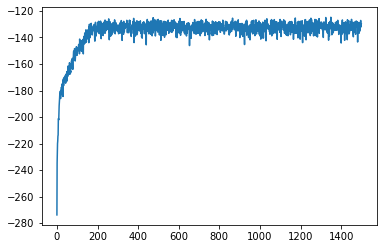

In [41]:
plt.plot(scores)
plt.show()